# Fairbanks Capital

Cole Fairbanks

# Client Churn Using Tree-Based Classification Models

#### Table of Content

1. Project Summary
2. Data Source
3. Load Libraries & Data
4. Feature Engineering
5. Descriptive Statistics
6. Train, Test, Split
7. Decision Tree Classifier
8. Random Forest Classifier
9. AdaBoost & XGBoost Classifiers
10. Business Value Add

#### Project Summary

Start Summary here.

#### Data Source

The following client churn data feeds various classification dt_models that utilize tree-methods (decision trees, random forests, and gradient boosted trees).  Toward the end of the notebook, there is a comparison in performance metrics across these dt_models.

https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers


* churn.csv: Client churn data for bank customers. Contains variables:

    * CustomerId: contains random values and has no effect on customer leaving the bank
    * Surname: the surname of a customer has no impact on their decision to leave the bank.
    * CreditScore: can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.
    * Geography: a customer’s location can affect their decision to leave the bank.
    * Gender: it’s interesting to explore whether gender plays a role in a customer leaving the bank.
    * Age: this is certainly relevant, since older customers are less likely to leave their bank than younger ones.
    * Tenure: refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.
    * Balance: also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.
    * NumOfProducts: refers to the number of products that a customer has purchased through the bank.
    * IsActiveMember: active customers are less likely to leave the bank.
    * EstimatedSalary: as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.
    * Exited: whether or not the customer left the bank.

**The goal is to  create a dt_model that predicts whether a client will churn based their attributes.**

#### Load Libraries & Data

In [278]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
import xgboost as xgb
from xgboost import XGBClassifier, plot_tree
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, make_scorer

After importing the required libraries, the churn.csv file is read into a pandas dataframe with the first 5 rows displayed.

In [279]:
df = pd.read_csv('/Users/colefairbanks/GitHub/trees-clientchurn-banks/churn.csv')
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### Feature Engineering

The importance of feature engineering cannot be underscored enough when building machine learning dt_models.  The old mantra, "garbage-in garbage-out," can many times be remedied by handling missing data, non-linearity, complex dimensionality, etc. during the feature engineering process.  By scrubbing clean the data flowing into your dt_model, you can expect vastly improved performance.

That said, it is always a good idea to use the .info() function to get a feel for dataset quality.

In [280]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


As you can see, this dataset practically came gift-wrapped - no null values, correct data types, and a nice 10,000 row sample.  However, there is missing information that was probably removed on-purpose for privacy reasons that we can recreate for real-world application; namely, email address and phone number.

* Email addresses are created based on "Surname" and simply adding "@gmail.com."
* Phone numbers are random, unique 9-digit numbers.

In [281]:
df['Email'] = df['Surname'].str.lower() + '@gmail.com'

In [282]:
df['Phone'] = [random.randint(100000000, 999999999) for i in range(10000)]
df['Phone'] = df['Phone'].astype(str)
df['Phone'] = df['Phone'].str[:3] + '-' + df['Phone'].str[3:6] + '-' + df['Phone'].str[6:]

Data Scientists who work with classification dt_models and customer data tend to pay attention to whether each column contains numeric or string values in addition to how they are grouped.  CustomerId, Surname, Email, and Phone, while typical fields, present a problem - they are unique and likely irrelevant.  Therefore, we should remove these columns; however, before doing so, we need a way to add back this information later, as our ultimate goal is to target these customers to prevent them from churning.  And so, we will create mapping dictionaries that are tied to unique customer IDs.

In [283]:
email_dict = df[['CustomerId', 'Email']].set_index('CustomerId')['Email'].to_dict()
phone_dict = df[['CustomerId', 'Phone']].set_index('CustomerId')['Phone'].to_dict()
surname_dict = df[['CustomerId', 'Surname']].set_index('CustomerId')['Surname'].to_dict()

With the information saved, we can now drop the irrelevant columns.

In [284]:
df.drop(['Surname', 'Email', 'Phone'], axis=1, inplace=True)

However, we are not going to drop "CustomerId", as this what our dictionaries eventually will map to.  Instead, we are going to set the index to this field instead of using standard row numbers.  Doing so ensures we can retain this information throughout the dt_model without adding additional noise.

In [285]:
df = df.set_index('CustomerId')

Another problem we face as of July 12, 2023 is sklearn's inability to interpret non-numerical text as categorical.  This affects "Gender" and "Geography" within our current dataframe, which contain: Female, Male, France, Germany, and Spain.

In [286]:
df.groupby(['Gender'], as_index=False).count()[['Gender']]

,Gender
0,Female
1,Male


In [287]:
df.groupby(['Geography'], as_index=False).count()[['Geography']]

,Geography
0,France
1,Germany
2,Spain


Our first instinct might be to assign a value like 0 to Female and 1 to Male - or 0 to France, 1 to Germany, and 2 to Spain.  However, this is risky, because sklearn might interpret these as ordinal values, which inserts bias via an unintentionally ranking.

Instead, we can implement a technique called "one-hot encoding" using the .get_dummies() pandas function.  This involves automatically creating new columns with binary classifications of True and False.  You will notice astype(int) is added - this converts True and False to integers 0 and 1.

* Bonus: drop_first=True is included to eliminate "Geography_France."  Why? To prevent multicollinearity - correlations between features.  Having drop_first is good statistical hygiene in my opinion, especially if dt_models like these are designed to be scaled eventually.

In [288]:
df = pd.get_dummies(df, drop_first=True).astype(int)

Let's order our columns and take a look at our cleaned, numeric dataframe.

In [289]:
df = df[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'
         , 'Geography_Germany', 'Geography_Spain', 'Gender_Male', 'Exited']]
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Exited
CustomerId,,,,,,,,,,,,
15634602,619,42,2,0,1,1,1,101348,0,0,0,1
15647311,608,41,1,83807,1,0,1,112542,0,1,0,0
15619304,502,42,8,159660,3,1,0,113931,0,0,0,1
15701354,699,39,1,0,2,0,0,93826,0,0,0,0
15737888,850,43,2,125510,1,1,1,79084,0,1,0,0


Looks good.  Next, descriptive statistics.

#### Descriptive Statistics

Descriptive statistics summarize and describe the main features of datasets and help data science professionals gain a quick understanding of their properties, which can guide further analyses and decision-making processes.

For classification models, class imbalance is always front-and-center when examining datasets for the first time.  This can be done using a seaborn count plot and will determine model selection, k-fold accuracy evaluation, and more.  In the visualization below, we can see that out of 10,000 clients, 2,000 or 20% will churn.  Given this is not closer to a 50-50 split, we are working with a class imbalance and need to act accordingly.

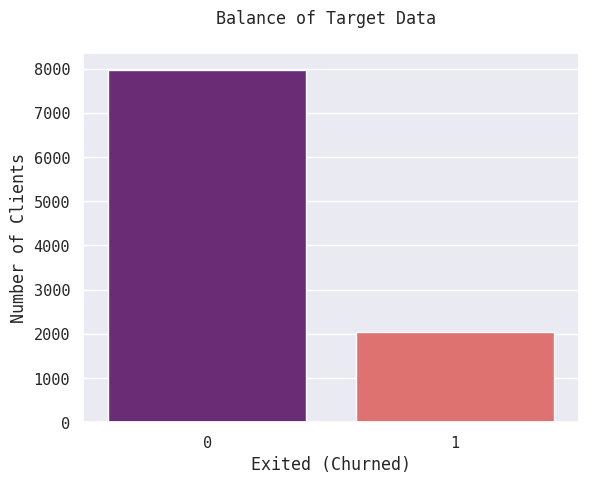

In [290]:
sns.countplot(data=df, x='Exited', palette='magma')
plt.title('Balance of Target Data \n')
plt.xlabel('Exited (Churned)')
plt.ylabel('Number of Clients');

In addition to class imbalance, another useful insight is a correlation heatmap that establishes the strength of relationships between features.  In the heatmap below, we are focused on which features impact "Exited," our target variable, the most.  In this case, it is "Age" and "IsActiveMember," which may be worth exploring more.

In [291]:
correlation_matrix = df.corr()

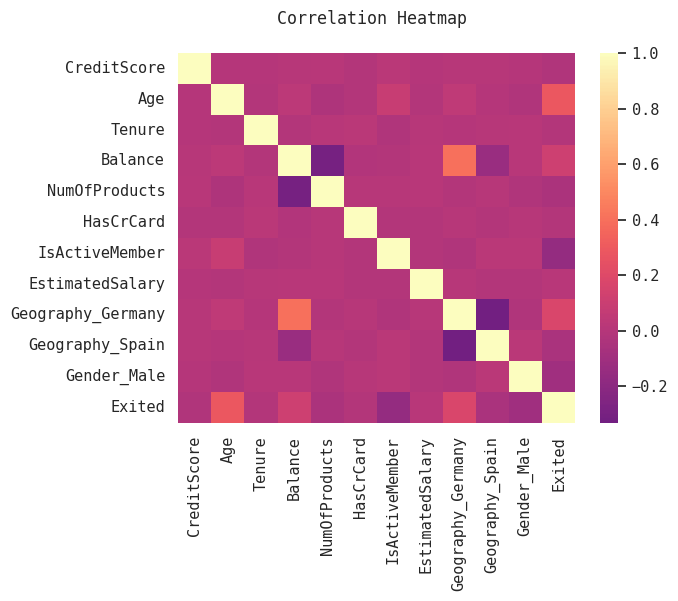

In [292]:
sns.heatmap(correlation_matrix, annot=False, cmap="magma", center=0)
plt.title("Correlation Heatmap \n ")
plt.show()

Digging deeper - "Age" seems to have the strongest relationship with client churn.  Since age is numerical and ranges from clients in their 20s to 90s, a box plot would be great for visually evaluating median ages and the average spread for clients who stayed and churned.  One immediate insight from the box plot below is that clients who are older tend to churn more than younger clients.  A question for later might be, why?

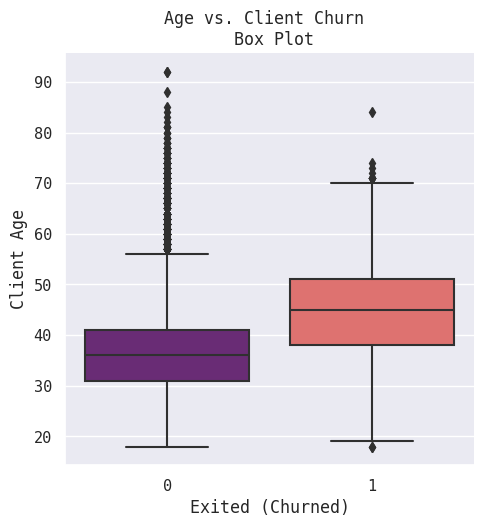

In [293]:
sns.catplot(x='Exited',y='Age',data=df,kind='box',palette='magma')
plt.title('Age vs. Client Churn \n Box Plot')
plt.xlabel('Exited (Churned)')
plt.ylabel('Client Age');

#### Train, Test | Split

As a first step, the feature columns need to be separated from the target, "Exited."

In [294]:
X = df.iloc[:, :-1]
y = df['Exited']

Once seperated, we can implement sklearn's classic train_test_split() function.  A standard test size of 0.20 is used with a random state for replication.

In [295]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

#### Helper Functions

So, there are 3 helper functions that were created to minimize code duplication.

1. **Model Metrics:**  the first function expands on sklearn's built-in classification and confusion matrix. It does this by creating a 1-row dataframe containing our custom accuracy metrics (more on that in the section below), which lays out visually the cost of doing nothing versus implementing the predictive model.

2. **Metrics Plots:** the second function creates a compact, side-by-side visualization that highlights the confusion matrix and feature importance with the same color palette and font.

3. **Hyperparameter Plots:** the third function displays the grid search results of the best performing model visually so that a Data Scientist could determine which hyperparameters would be optimal.

In [296]:
def model_metrics(model, model_name, renewal_rate, acquisition_rate):
    
    predictions = model.predict(X_test)
    cr = classification_report(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)

    #pulls the 
    fp = int(cm[0][1])
    fn = int(cm[1][0])
    tp = int(cm[1][1])
    tn = int(cm[0][0])
  
    #dataframe
    metrics = [model_name, tn, fp, fn, tp, renewal_rate, acquisition_rate]
    column_names = ['Model', 'TN', 'FP', 'FN', 'TP', 'RenewRate', 'AcquireRate']
    df = pd.DataFrame([metrics], columns=column_names)
    blank_index = [''] * len(df)
    df.index = blank_index

    df['CostDoingNothing'] = ((df['FN'] + df['TP']) * acquisition_rate)
    df['CostImplementingModel'] = ((df['TP'] * 50) + (df['FP'] * 50) + (df['FN'] * 100))

    #formula for cost savings
    df['CostSavings'] =  df['CostDoingNothing'] -  df['CostImplementingModel']

    return df

In [297]:
def metrics_plots(model, model_name, cm):
    
    #creates subplot that enables two visualizations in the same cell
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    #converts sklearn's feature_importances_ array into a pandas dataframe and drops any rows below 0
    model.feature_importances_
    df = pd.DataFrame(index=X.columns,data=model.feature_importances_,columns=['Purity']).sort_values(by='Purity', ascending=False)
    df = df[df['Purity'] > 0]

    #sets color palette for heatmap, barplot, and makes font consistent with Jupyter font
    color_palette = sns.color_palette('magma', as_cmap=True)
    heatmap_colors = [color_palette(x) for x in np.linspace(1, 0, len(df))]
    sns.set(font='monospace')

    #plots confusion matrix and changes titles and labels
    plot1 = sns.heatmap(cm, cmap=color_palette, annot=True, fmt='g', vmax=400, ax=axes[0])
    axes[0].set_title(model_name + ': Confusion Matrix \n')
    axes[0].set_xlabel('\n Predictions')
    axes[0].set_ylabel('True Values \n')
    axes[0].xaxis.set_ticklabels(['No Exit', 'Exited'])
    axes[0].yaxis.set_ticklabels(['No Exit', 'Exited']);

    #plots feature importance as a barplot
    plot2 = sns.barplot(data=df, x=df.index, y='Purity', palette=heatmap_colors)
    axes[1].set_ylabel('Purity \n')
    axes[1].set_title('Feature Importance \n')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
    sns.despine(ax=axes[1], top=True, right=True);

In [340]:
def hyperparameter_plots(mean_test_scores, max_features, n_estimators):

    #creates subplot that enables two visualizations in the same cell
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    #sets color palette for heatmap, barplot, and makes font consistent with Jupyter font
    color_palette = sns.color_palette('magma', as_cmap=True)
    sns.set(font='monospace')

    #plots tree depth as a scatterplot
    plot2 = sns.scatterplot(x=max_features, y=mean_test_scores, palette=color_palette, hue=mean_test_scores, legend=False, ax=axes[0])
    axes[0].set_title('Optimal Hyperparamters \n\n')
    axes[0].set_xlabel('\n Tree Depth')

    #plots learning rate as a scatterplot
    plot3 = sns.scatterplot(x=n_estimators, y=mean_test_scores, palette=color_palette, hue=mean_test_scores, legend=False, ax=axes[1])
    axes[1].set_xlabel('\n Learning Rate');

#### Performance Metrics & Evaluation

Let's talk about "accuracy" and what constitutes as the "best" model.  If this was a purely academic exercise, the classification report that includes precision, recall, f1, and accuracy would be enough for a decent grade.  However, the ultimate goal of one of these models deployed in the real world is to generate value in terms of dollars.  Therefore, we need custom metrics that reflect the highest amount of dollars saved or generated.  In the case of client churn, here is what the formula looks in simplest terms:


> COST OF DOING NOTHING - COST OF IMPLEMENTING ML MODEL = COST SAVINGS

> We know each time a client is lost, $100 is spent acquiring a new one and so, we know:

> COST OF DOING NOTHING = NUMBER OF CHURNED CLIENTS * 100
> COST OF DOING NOTHING = (FALSE NEGATIVES + TRUE POSITIVE) * ACQUISITION RATE

> The cost of implementing the ML model is a bit more complex because if we do save a customer, it costs $50 in discounts and advertising.  However, our model will inevitably miss to > > detect some clients and therefore, our false negatives will still result in $100 loss:

> COST OF IMPLEMENTING MODEL = (NUMBER OF CLIENTS WHO WE SAVED FROM CHURNING * 50) + (NUMBER OF CLIENTS WE THOUGHT WOULD CHURN WHO DIDN'T * 50) + (NUMBER OF CHURNED CLIENTS * 100)
> COST OF IMPLEMENTING MODEL = (TRUE POSITIVES * 50) + (FALSE POSITIVES * 50) + (FALSE NEGATIVES * 100)

Now if you are asking, "Well, doesn't this assume there's a 100% capture rate?" or "What about the cost of compute?" then you are on the right track.  We will discuss some of those assumptions at the end of this notebook.  For simplicity's sake though, we will assume 100% capture, no computing costs, and no concessions for renewal aside from marketing.

#### Decision Tree Classifier

Decision trees are a supervised learning algorithm that is used for classification tasks. At each step of building a tree, the algorithm selects a feature, minimizes the Gini (or entropy) impurity at each node, and makes class predictions based on majority-voting system.  One benefit of decision trees compared to more complex ML methods like neural networks is their interpretability. Decision trees are highly interpretable, as the decision-making process can be visualized in a tree-like structure. However, they are also prone to overfitting, especially if their size grows too large.

**A Note on Gini Impurity:**

Gini Impurity tells us the probability of misclassifying an observation, with 1 being the most impure and 0 being pure - the closer to 0, the better.  This criteria represented by the following math equation is used to determine the splits of each tree node:

> GINI IMPURITY FOR A LEAF = 1 - (probability of "Churn")^2 - (probability of "No Churn")^2

> TOTAL GINI IMPURITY = weighted average of **gini impurities** for the **leaves**

For more information on the math behind Gini, check out [StatQuest's YouTube explanation](https://www.youtube.com/watch?v=_L39rN6gz7Y&t=836s).


In [299]:
dt_model = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=4)
dt_model.fit(X_train,y_train)
dt_predictions = dt_model.predict(X_test);

After fitting the model and making predictions, we will call the typical classification report and confusion matrix functions as well as our custom metrics function that will display everything we need to evaluate the model.

In [300]:
dt_cr = classification_report(y_test, dt_predictions)
dt_cm = confusion_matrix(y_test, dt_predictions)
dt_metrics_df = model_metrics(dt_model, 'Decision Tree', 50, 100)

In [301]:
print(dt_cr)
dt_metrics_df.head()

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1577
           1       0.65      0.47      0.55       423

    accuracy                           0.83      2000
   macro avg       0.76      0.70      0.72      2000
weighted avg       0.82      0.83      0.82      2000



,Model,TN,FP,FN,TP,RenewRate,AcquireRate,CostDoingNothing,CostImplementingModel,CostSavings
,Decision Tree,1472,105,225,198,50,100,42300,37650,4650


By calling the metrics_plot function, we can visualize both the confusion matrix and feature importance of the tree-based model.

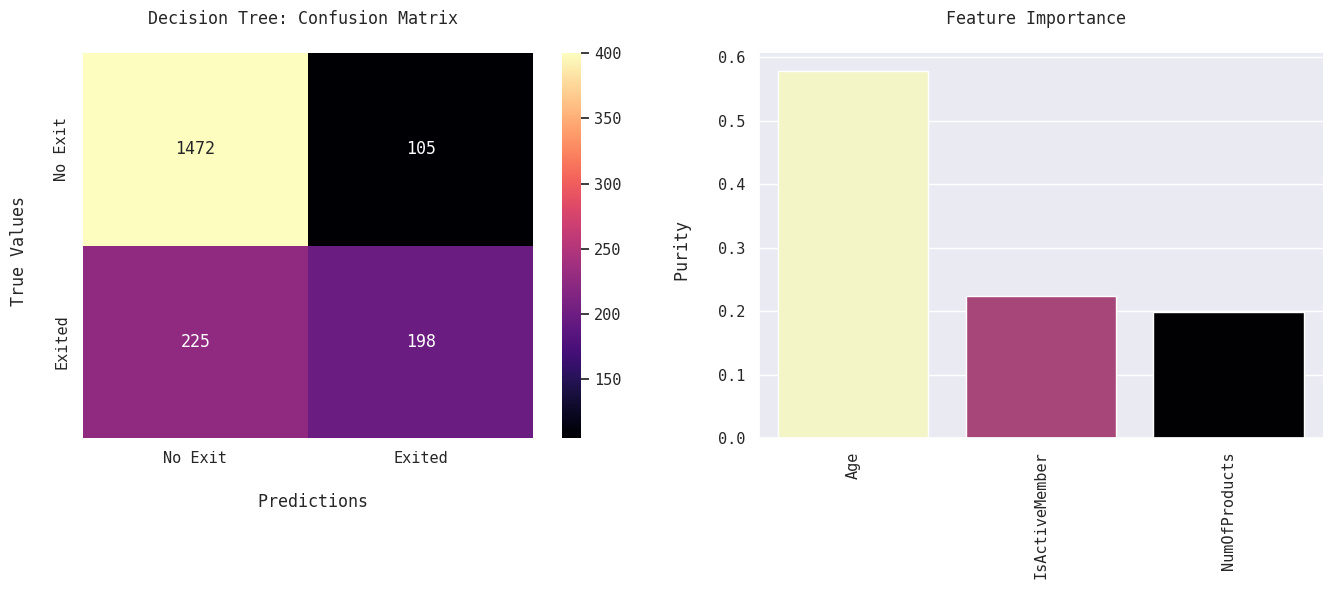

In [302]:
metrics_plots(dt_model, 'Decision Tree', dt_cm)

For basic decision trees, sklearn as a plot_tree function that let's you visualize how the tree is split using a gini index.  Generally, if you follow the branches to the left that means "yes, churned" and to the right means "no, did not churn."  Notice the Gini numbers - the lower the better.

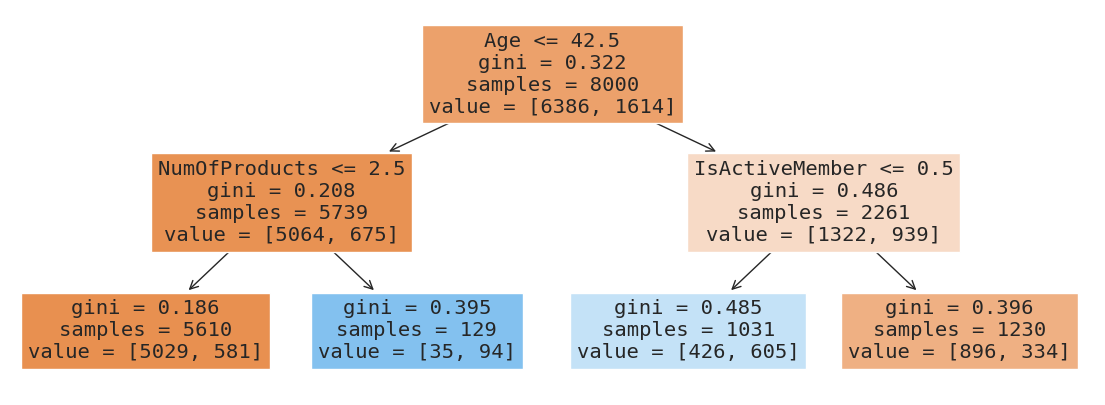

In [303]:
plt.figure(figsize=(14,5))
tree.plot_tree(dt_model,filled=True,feature_names=list(X.columns));

#### Random Forest Classifier

Random Forests are an evolution of simple decision trees.  Using an ensemble approach, random forests combine multiple decision trees to create more robust, accurate models. They do this by implementing random sampling with replacement, known as "bootstrapping," as well as random feature selection.  Bootstrapping involves selecting multiple random samples with replacement, which means each subset may contain duplicate samples.  Random forests also consider a random subset of features rather than using all the features.  By introducing more randomness into the modeling process, the result is a versatile model that is extraordinarily hard to overfit.

In [304]:
rfc_model = RandomForestClassifier(class_weight='balanced', bootstrap=True, random_state=101)
rfc_model.fit(X_train, y_train)
rfc_predictions = rfc_model.predict(X_test);

In [305]:
rfc_cr = classification_report(y_test, rfc_predictions)
rfc_cm = confusion_matrix(y_test, rfc_predictions)
rfc_metrics_df = model_metrics(rfc_model, 'Random Forest', 50, 100)

In [306]:
print(rfc_cr)
rfc_metrics_df.head()

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1577
           1       0.81      0.51      0.62       423

    accuracy                           0.87      2000
   macro avg       0.84      0.74      0.77      2000
weighted avg       0.86      0.87      0.86      2000



,Model,TN,FP,FN,TP,RenewRate,AcquireRate,CostDoingNothing,CostImplementingModel,CostSavings
,Random Forest,1526,51,208,215,50,100,42300,34100,8200


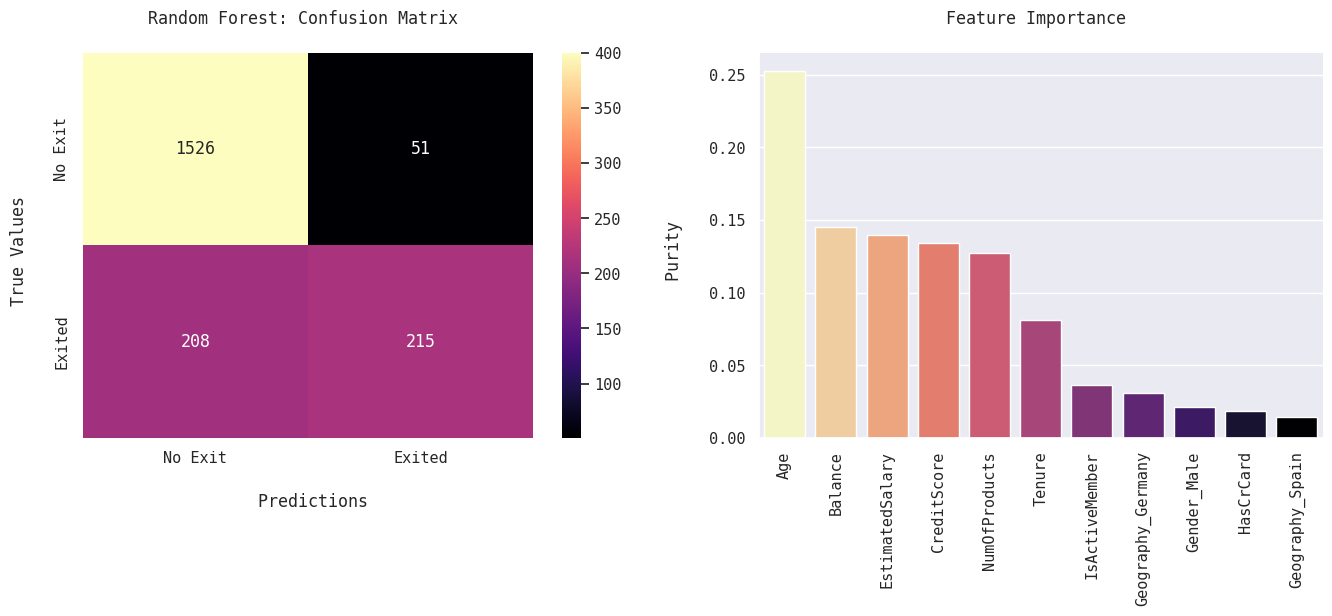

In [307]:
metrics_plots(rfc_model, 'Random Forest', rfc_cm)

#### AdaBoost

Boosting.  Weak learners are models too simple to perform well on their own - they typically have 1 node and 2 leaves.  AdaBoost (Adaptive Boosting) assembles weak learners, combines them using weighted sums, and then adapts to adjust misclassified instances.  Unlike random forests that assemble decision trees in parallel, AdaBoost does it sequentially in series, which enables "slow learning."  Each stump represents the strength of a feature and changing the alpha  coefficient allows us to intelligently combine the importance of each feature.

In [308]:
ada_model = AdaBoostClassifier(random_state=101)
ada_model.fit(X_train, y_train)
ada_predictions = ada_model.predict(X_test);

In [309]:
ada_cm = confusion_matrix(y_test, ada_predictions)
ada_cr = classification_report(y_test, ada_predictions)
ada_metrics_df = model_metrics(ada_model, 'AdaBoost', 50, 100)

In [310]:
print(ada_cr)
ada_metrics_df.head()

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1577
           1       0.76      0.52      0.62       423

    accuracy                           0.86      2000
   macro avg       0.82      0.74      0.77      2000
weighted avg       0.86      0.86      0.85      2000



,Model,TN,FP,FN,TP,RenewRate,AcquireRate,CostDoingNothing,CostImplementingModel,CostSavings
,AdaBoost,1508,69,204,219,50,100,42300,34800,7500


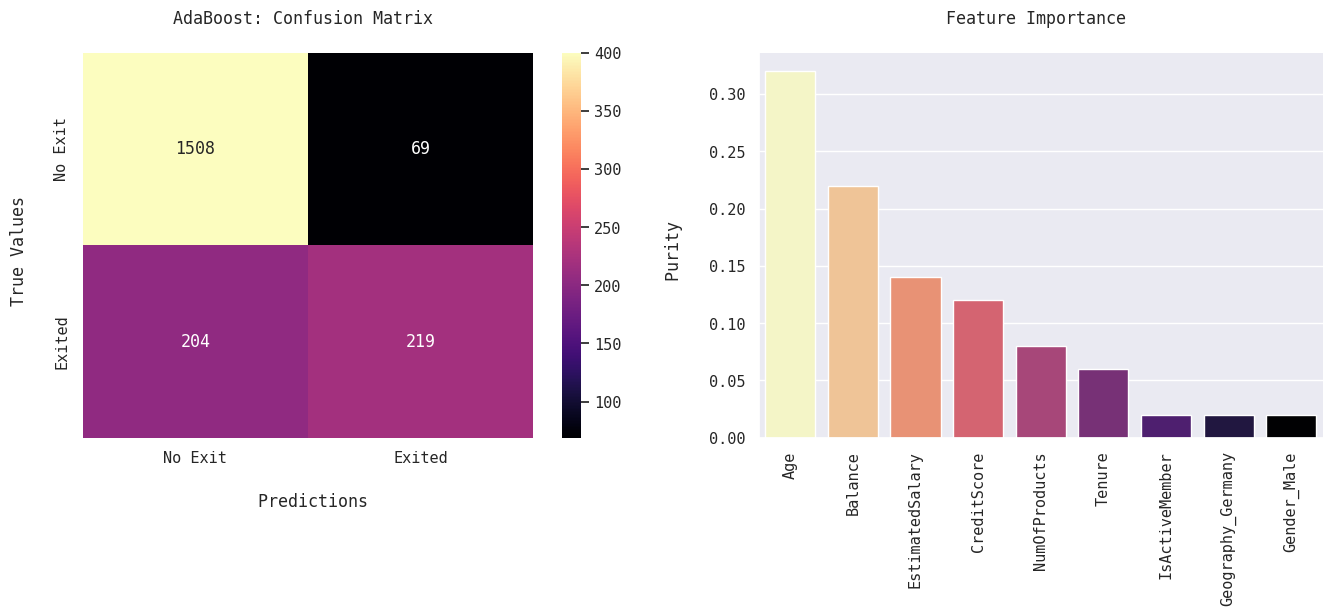

In [311]:
metrics_plots(ada_model, 'AdaBoost', ada_cm)

#### XGBoost

Extreme Gradient Boosting or "XGBoost" is similar to Adaboost in its sequential nature.  However, instead of altering alpha coefficients, XGBoost iteratively minimizes the residual error from each previous tree until the loss function is optimal.  Additionally,  unlike AdaBoost, XGBoost includes additional regularization techniques, such as L1 and L2 regularization, to prevent overfitting.

In [312]:
xgb_model = xgb.XGBClassifier(learning_rate=0.03, max_depth=3, scale_pos_weight=1, random_state=101)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

In [313]:
xgb_cm = confusion_matrix(y_test, xgb_predictions)
xgb_cr = classification_report(y_test, xgb_predictions)
xgb_metrics_df = model_metrics(xgb_model, 'XGBoost', 50, 100)

In [314]:
print(xgb_cr)
xgb_metrics_df.head()

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1577
           1       0.81      0.45      0.58       423

    accuracy                           0.86      2000
   macro avg       0.84      0.71      0.75      2000
weighted avg       0.86      0.86      0.85      2000



,Model,TN,FP,FN,TP,RenewRate,AcquireRate,CostDoingNothing,CostImplementingModel,CostSavings
,XGBoost,1532,45,231,192,50,100,42300,34950,7350


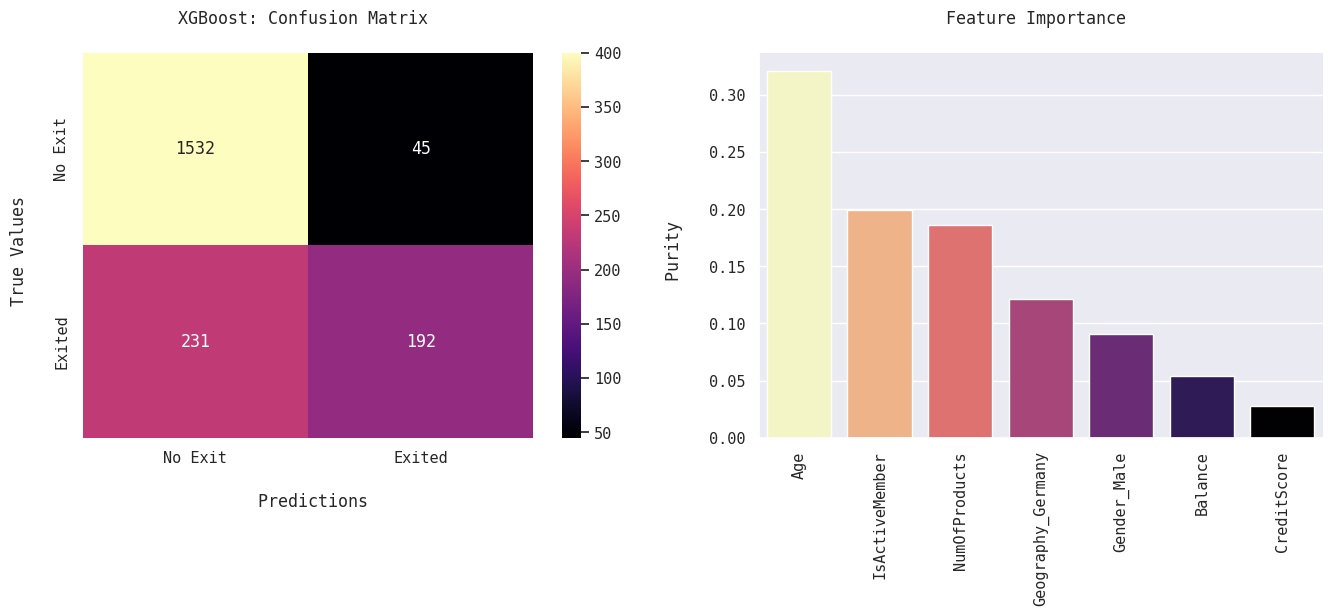

In [315]:
metrics_plots(xgb_model, 'XGBoost', xgb_cm)

Because XGBoost is sequential, you cannot display simply 1 tree or several parallel trees; however, you can display the tree that produced the highest gain in accuracy and plot it, although you need to download the right packages to do it.

In [316]:
highest_gain_tree = xgb_model.best_iteration

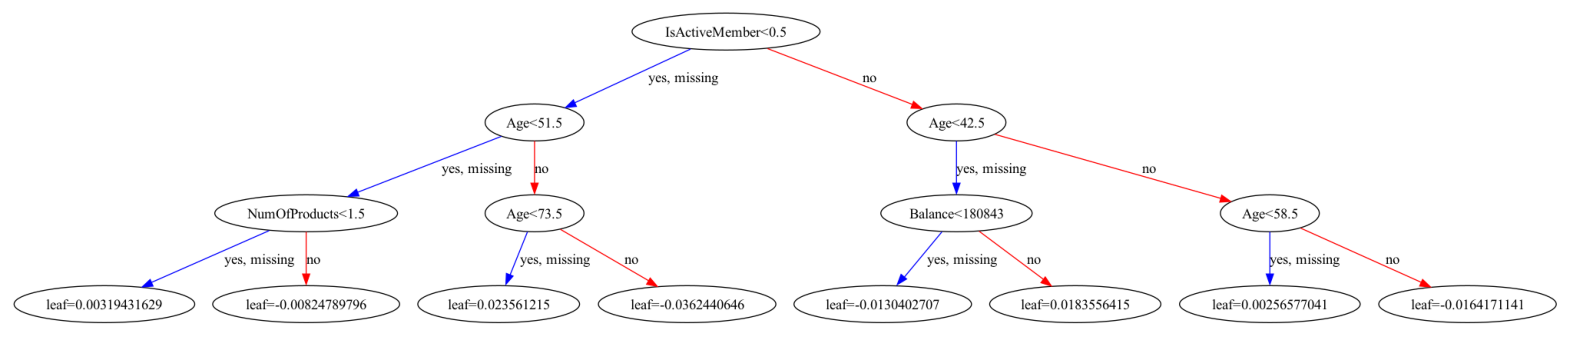

In [317]:
fig, ax = plt.subplots(figsize=(20, 10))
xgb.plot_tree(xgb_model, num_trees=highest_gain_tree, ax=ax)
plt.show()

#### Model Optimization

top accuracy doesn't exactly mean profitability.  

In [318]:
metrics_df = pd.concat([dt_metrics_df, rfc_metrics_df, ada_metrics_df, xgb_metrics_df]) 
metrics_df.head()

,Model,TN,FP,FN,TP,RenewRate,AcquireRate,CostDoingNothing,CostImplementingModel,CostSavings
,Decision Tree,1472,105,225,198,50,100,42300,37650,4650
,Random Forest,1526,51,208,215,50,100,42300,34100,8200
,AdaBoost,1508,69,204,219,50,100,42300,34800,7500
,XGBoost,1532,45,231,192,50,100,42300,34950,7350


reducing false negatives or Type II errors ended up yielding massive savings because of the $50 vs. $100 savings difference

In [319]:
def custom_score(y_test, model_predictions):
    tn, fp, fn, tp = confusion_matrix(y_test, model_predictions).ravel()
    score = ((fn + tp) * 100) - ((tp * 50) + (fp * 50) + (fn * 100))
    return score

In [320]:
#custom_score(y_test, model_predictions)

# Create the custom scorer
custom_scorer = make_scorer(custom_score, greater_is_better=True)

In [321]:
# Define the parameter grid
param_grid = {

    'n_estimators': [50, 100, 200, 300, 400, 500, 600],
    'max_features': ['sqrt', 'log2'],

}

#Stratified K Fold

In [322]:
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

Create the GridSearchCV object with custom scoring

In [323]:
grid_search = GridSearchCV(estimator=rfc_model, param_grid=param_grid, scoring=custom_scorer, cv=strat_kfold)

Fit the grid search to your data

In [324]:
grid_search.fit(X_train, y_train);

In [325]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Optimized Hyperparameteres:", best_params)
print("Best Score:", best_score)

Optimized Hyperparameteres: {'max_features': 'sqrt', 'n_estimators': 500}
Best Score: 4960.0


In [333]:
results = grid_search.cv_results_

#
mean_test_scores = results['mean_test_score']
std_test_scores = results['std_test_score']

#
hyperparameters = results['params']

#
max_features = [entry['max_features'] for entry in hyperparameters]
n_estimators = [entry['n_estimators'] for entry in hyperparameters]

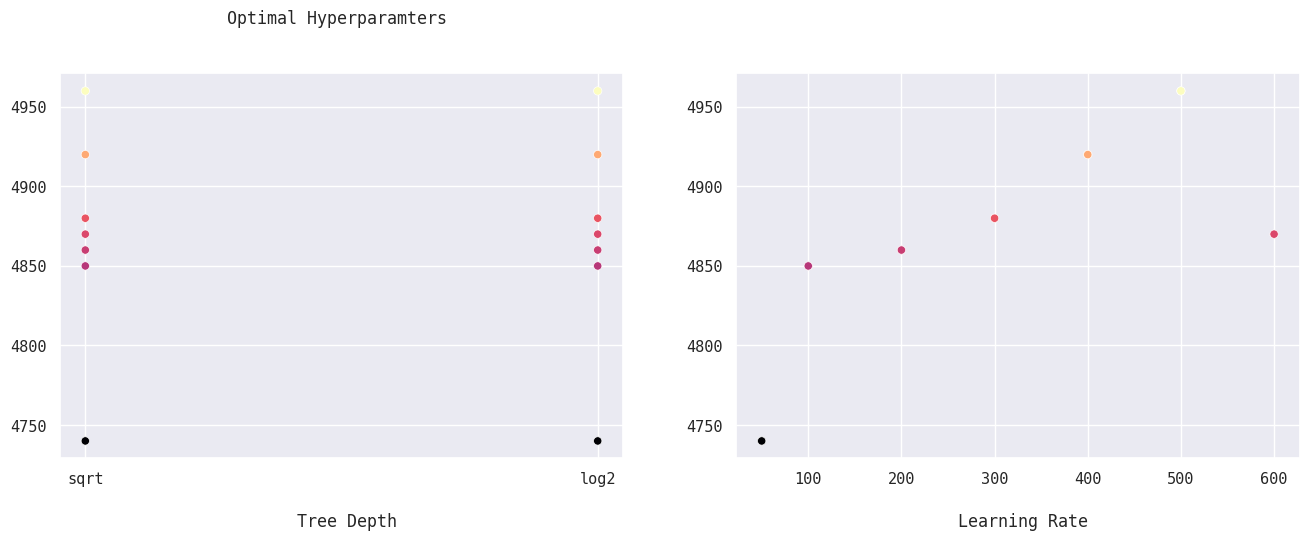

In [341]:
hyperparameter_plots(mean_test_scores, max_features, n_estimators)

In [ ]:
X_test.head()

In [ ]:
test = X_test
test['Exited'] = xgb_predictions
test = test.loc[test['Exited'] == 1]
test = test.reset_index(drop=False)
test = test['CustomerId']


In [ ]:
test

In [ ]:
#Assumes after we identify which clients will churn that 100% of them will stay if we send them promotional material.